# Applied Data Analysis: CMU Movie Summary Corpus

## Dataset Details
This dataset contains metadata and plot summaries for over 42,000 movies. The dataset is a rich resource for exploring relationships between movies, characters, and plot content.

- **Name**: CMU Movie Summary Corpus
- **Source**: [CMU Movie Summary Corpus Dataset](https://www.cs.cmu.edu/~ark/personas/)
- **Size**: 46 MB (compressed)
- **Typology**: Text + Graphs + Numerical Data
- **Tags**: Movies, Characters, Plot Summaries, Metadata

The dataset contains:
- **Movie Metadata**: Information about the movies such as titles, genres, release dates.
- **Character Metadata**: Details about the characters in each movie.
- **Plot Summaries**: Textual summaries of movie plots extracted from Wikipedia.

You can read more about the dataset in the paper: [Bamman et al., 2013](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

## Part 1 : Understanding the data
In this section, we will begin by loading the dataset and performing some initial exploratory data analysis (EDA). This will help us understand the structure and content of the data, identify any missing values, and get a sense of the distributions and relationships between different variables.

In [226]:
# Imports
import importlib
from collections import Counter
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import src.utils.data_utils as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import json

#%pip install SPARQLWrapper

importlib.reload(CMU_dataset_dataloader)
importlib.reload(data_utils)

# Constants
CMU_DATA_DOWNLOAD_PATH = 'https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
CMU_DATA_PATH_INITIAL = 'data/initial/'
CMU_DATA_PREPROCESSED_PATH = 'data/preprocessed/'

sns.set_palette("colorblind") 
sns.set_style("whitegrid")

In [206]:
# Load the plot summaries
print("Plot Summaries:")
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=['movie_id', 'summary'])
df_plots = plots.data

df_plots.sample(5)

Plot Summaries:


,movie_id,summary
30958,33025390,The film concerns the manhunt for David Martin...
13229,25868462,"At 17, William Lanctôt-Couture , an ice hockey..."
40451,28661161,"In 1946, Gesualdo is a recovering Second Worl..."
8921,8144777,"Hairi Saiful Apek, is a loser who lives in Met..."
19735,18664076,"As a child, Ray Reiter was the sole survivor ..."


In [207]:
# Load the movie metadata
print("\nMovie Metadata:")
categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
    ]
movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data

df_movies.sample(10)


Movie Metadata:


,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
28312,23409969,/m/06w7hkm,Chor Police,1983,NaN,90.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/07s9rl0..."
51320,2328249,/m/0743bs,Hexed,1993-01-22,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/01jfsb"": ""Thriller""..."
77584,19663841,/m/04mxgl5,In the Cool of the Day,1963-03,NaN,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D..."
29358,14511175,/m/03d5wpx,Dangerous Lies,1921-09-18,NaN,66.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
58305,33010594,/m/0h55gr6,Mated in the Wilds,1921,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",{},"{""/m/06ppq"": ""Silent film""}"
59820,6992716,/m/0g_bch,All Souls' Day,1962,NaN,93.0,"{""/m/05qqm"": ""Polish Language""}","{""/m/05qhw"": ""Poland""}","{""/m/07s9rl0"": ""Drama""}"
43235,15747276,/m/03ns4_5,Rose Hill,1997-04-20,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04xvlr"": ""Period piece"", ""/m/03btsm8"": ""A..."
13696,33044333,/m/027p4zg,The Blonde from Buenos Aires,NaN,NaN,80.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0f8l9c"": ""France"", ""/m/0jgd"": ""Argentina""}","{""/m/06cvj"": ""Romantic comedy""}"
66445,4021962,/m/0bczch,African American Lives,2006,NaN,240.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/03g3w"": ""History"", ""/m/0jtdp"": ""Documenta..."
13579,13517240,/m/03c7w_v,John Appa Rao 40 plus,2008-03-20,NaN,NaN,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/01z4y"": ""Comedy""}"


In [208]:
# Load the character metadata
print("\nCharacter Metadata:")
categories = [
    'wikipedia_movie_id', 
    'freebase_movie_id', 
    'release_date', 
    'character_name', 
    'actor_birth', 
    'actor_gender', 
    'actor_height', 
    'actor_ethnicity', 
    'actor_name', 
    'actor_age', 
    'freebase_character_actor_id', 
    'freebase_character_id', 
    'freebase_actor_id'
    ]
characters = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'character.metadata.tsv', categories=categories)
df_characters = characters.data
df_characters.sample(5)


Character Metadata:


,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_id,freebase_character_id,freebase_actor_id
363138,23995219,/m/07kd6rg,1937,Cappy Ricks,1894-07-25,M,1.80,NaN,Walter Brennan,NaN,/m/0g9c2k2,/m/0g9c2j1,/m/02f6s3
351607,147829,/m/012y5v,1984-05-04,NaN,1938-12-16,M,1.75,NaN,Wi Kuki Kaa,45.0,/m/0gcxh2k,NaN,/m/07k4kdr
81529,31601544,/m/0gmc8b5,1961-09-30,NaN,1936-08-13,F,1.60,/m/01rv7x,Vyjayanthimala,25.0,/m/0gw40wf,NaN,/m/0dm652
389184,33521974,/m/0h95f6r,2002-03,NaN,NaN,NaN,NaN,NaN,Lindsey Ingram,NaN,/m/0gdl320,NaN,/m/0gdl322
396695,92999,/m/0n1s0,1997-12-17,Aide #3,1972-06-16,M,1.78,/m/01j2qv,John Cho,25.0,/m/0h2h2sn,/m/0h2h2sq,/m/03l3jy


As we can see directly here, lot of that is invalid or inexistant. The only way to go : preprocessing.

### Plot summaries preprocessing

count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64


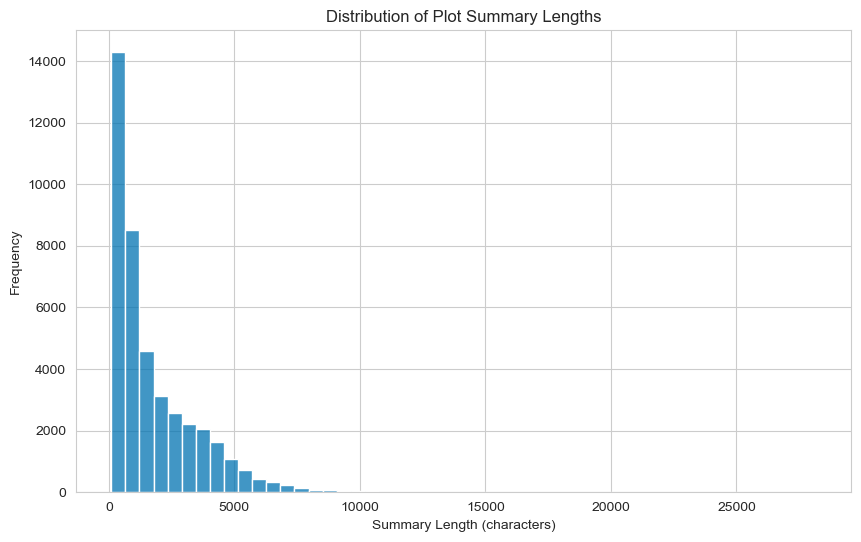

,movie_id,summary,summary_length
33162,22074076,"When Kelly and Michael decide to get married, ...",257
11498,8958592,"Hanna K. is the story of Hanna Kaufman, a chil...",1680
21454,11350779,The film begins with a title card describing H...,3992
2333,15205682,John Davis is a correspondent in England durin...,556
5180,27603418,A group of French military is attacked during ...,110


In [210]:
# Plot summaries pre-processing

# missing values
assert df_plots['summary'].isnull().sum() == 0
assert df_plots['movie_id'].isnull().sum() == 0

# Average plot summary length
df_plots['summary_length'] = df_plots['summary'].apply(len)
print(df_plots['summary_length'].describe())

plots.save_data(CMU_DATA_PREPROCESSED_PATH)

# # Plotting summary lengths distribution
plt.figure(figsize=(10,6))
sns.histplot(df_plots['summary_length'], bins=50)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

# # Print the preprocessed summaries
df_plots.sample(5)

### Movie metadata preprocessing

/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/957591325.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')
/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/957591325.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/957591325.py:22: Setti

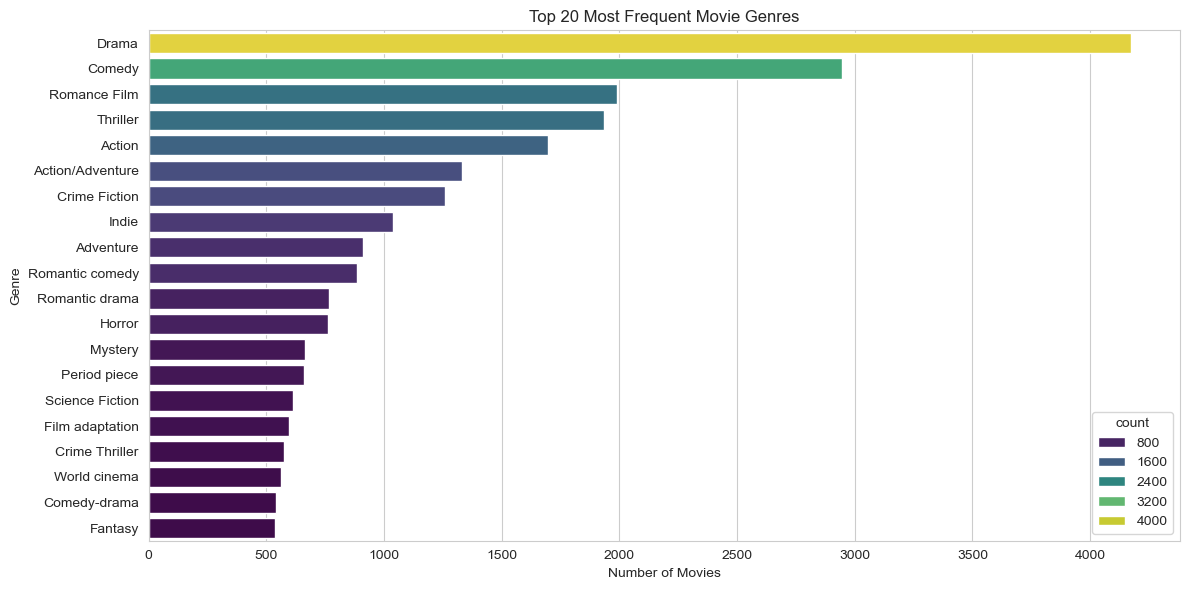

In [211]:
# Removing freebase (deprecated)
if 'freebase_movie_id' in df_movies.columns:
    df_movies.drop(columns=['freebase_movie_id'], inplace=True)

# missing values
df_movies = df_movies.dropna()

assert df_movies['wikipedia_movie_id'].isnull().sum() == 0
assert df_movies['movie_name'].isnull().sum() == 0
assert df_movies['release_date'].isnull().sum() == 0
assert df_movies['box_office_revenue'].isnull().sum() == 0
assert df_movies['runtime'].isnull().sum() == 0
assert df_movies['languages'].isnull().sum() == 0
assert df_movies['countries'].isnull().sum() == 0
assert df_movies['genres'].isnull().sum() == 0

# Format release date
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

# Extracting the language values for all rows
df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
df_movies['countries'] = df_movies['countries'].apply(data_utils.convert_to_dict)
df_movies['genres'] = df_movies['genres'].apply(data_utils.convert_to_dict)

movies.save_data(CMU_DATA_PREPROCESSED_PATH)

all_genres = df_movies['genres'].apply(lambda x: list(x.values()) if isinstance(x, dict) else []).explode()
genre_counts = Counter(all_genres)

genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
top_genres = genre_counts_df.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, y='genre', x='count', hue='count', palette="viridis")
plt.title('Top 20 Most Frequent Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

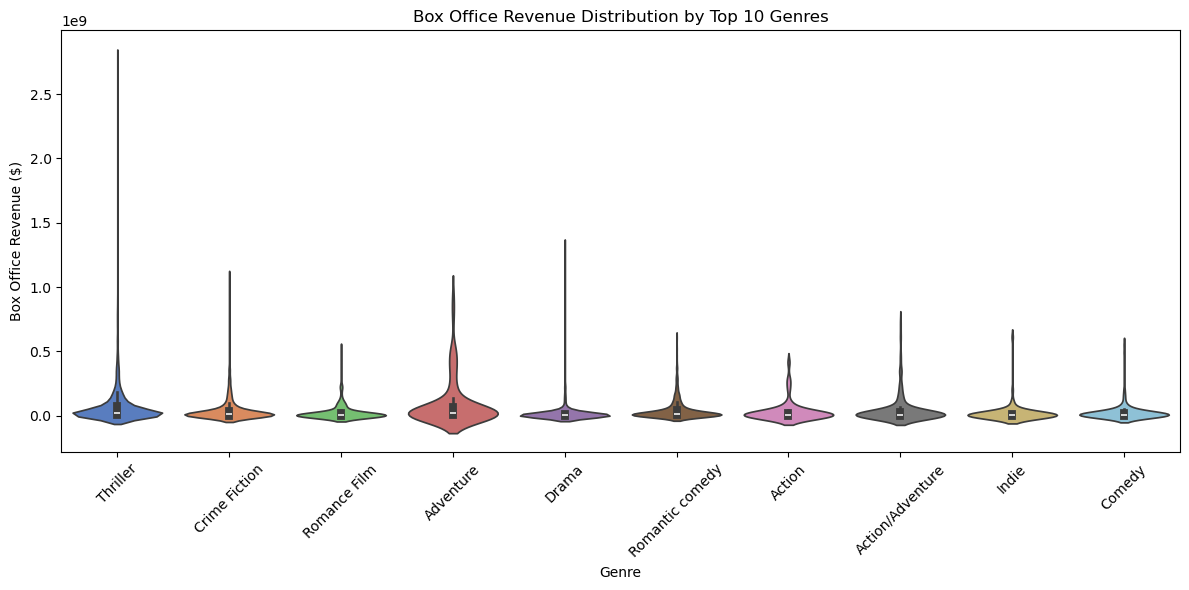

In [181]:
df_movies_one_genre = df_movies.copy()

def get_genre(row):
    if isinstance(row['genres'], dict) and row['genres']:
        return list(row['genres'].values())[0]
    return None

df_movies_one_genre['genres'] = df_movies_one_genre.apply(get_genre, axis=1)
df_movies_one_genre.groupby('genres')["box_office_revenue"].agg(['min', 'max', 'mean', 'median', 'std']).sort_values(by='mean', ascending=False)


top_10_genres_list = top_genres['genre'].head(10).tolist()
df_movies_one_genre_top_10 = df_movies_one_genre[df_movies_one_genre['genres'].isin(top_10_genres_list)]

plt.figure(figsize=(12, 6))
sns.violinplot(x='genres', y='box_office_revenue', data=df_movies_one_genre_top_10, hue='genres', legend=False)
plt.title('Box Office Revenue Distribution by Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Box Office Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Character metadata preprocessing

In [212]:
# Format release date
df_characters['actor_birth'] = pd.to_datetime(df_characters['actor_birth'], errors='coerce')

characters.save_data(CMU_DATA_PREPROCESSED_PATH)

# Merge the character dataframe with the movie dataframe
df_actors_revenues = df_characters.merge(df_movies[['wikipedia_movie_id', 'box_office_revenue']], how='inner')

# Keep only the relevant columns
df_actors_revenues = df_actors_revenues[['wikipedia_movie_id', 'box_office_revenue', 'actor_birth', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age']]

# Replace the freebase ethnicity ids with the actual names
# May take a while to run
# pip install SPARQLWrapper
ethnicities = {}

for ethnicity in df_actors_revenues['actor_ethnicity'].unique():
    # create_ethnicity_list will split if multiple (i.e 'Asian American' -> ['Asian', 'American'])
    ethnicities[ethnicity] = data_utils.create_ethnicity_list(data_utils.get_name_from_freebase_id(ethnicity))

# Map the freebase ids to the actual names
df_actors_revenues['actor_ethnicity'] = df_actors_revenues['actor_ethnicity'].map(ethnicities)


df_actors_revenues.sample(5)

,wikipedia_movie_id,box_office_revenue,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age
56972,76361,416000000.0,1883-01-30,M,NaN,[],Eddie Collins,NaN
29192,24586901,261930436.0,NaT,F,NaN,[],Stream,NaN
89797,5529883,2035468.0,1983-08-11,M,NaN,[],Adam Scarimbolo,NaN
98475,1228937,209073645.0,1964-04-06,F,1.778,[],Deborah Theaker,40.0
91771,10554740,2500000.0,1922-04-11,NaN,NaN,[],Joe Adams,32.0


## Part 2 : Exploratory Data Analysis to answer basic per-fearture's questions

This part aims to investigate how each feature that we find as being individually important is impacting the box office revenue. For that, we will answer the following questions :
- What is the average box office revenue by release season (e.g., summer, winter holiday, other)?
- Which 20 genres have the highest average box office revenue?
- How does film runtime correlate with box office revenue, and do longer or shorter films tend to perform better?
- Which 10 languages have the highest average box office revenue?
- Which 10 actors have the highest average box office revenue?
- Does ethnicity, age or gender of leading actors influences box office revenue?

### What is the average box office revenue by release season (e.g., summer, winter holiday, other)?
- Display average box office revenue by release season (summer, winter holiday, other).

Average Box Office Revenue by Release Season:
release_season
Holiday    5.219552e+07
Other      3.962152e+07
Summer     7.624119e+07
Name: mean, dtype: float64


/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/1085868291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['release_season'] = df_movies['release_date'].apply(data_utils.categorize_release_season)


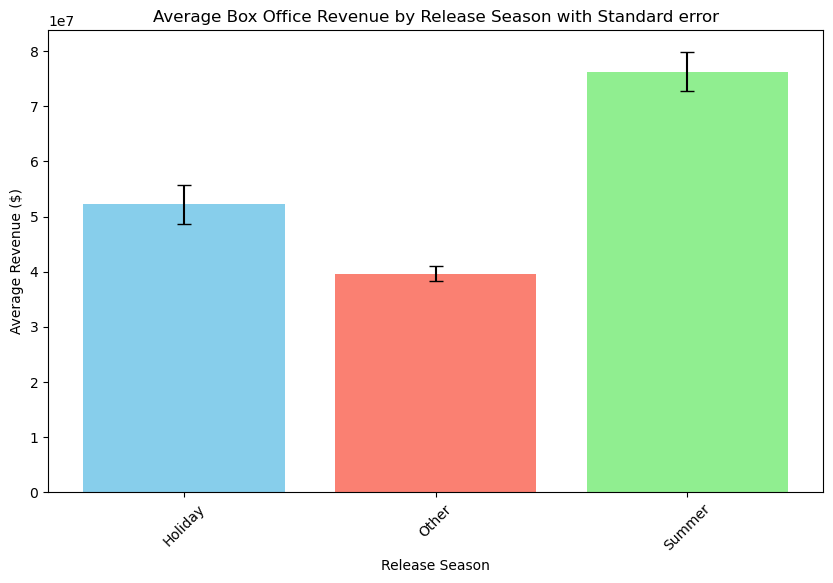

In [153]:
# Apply the function to create a 'release_season' column
df_movies['release_season'] = df_movies['release_date'].apply(data_utils.categorize_release_season)

# Calculate average revenues and standard error for each season
season_stats = df_movies.groupby('release_season')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Release Season:")
print(season_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(season_stats.index, season_stats['mean'], yerr=season_stats['sem'], color=['skyblue', 'salmon', 'lightgreen'], capsize=5)
plt.title('Average Box Office Revenue by Release Season with Standard error')
plt.xlabel('Release Season')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()


#### Analysis of Average Box Office Revenue by Release Season

The results indicate the following average revenues:

- **Holiday**: $52.20 million
- **Summer**: $76.24 million
- **Other**: $39.62 million

##### Observations

1. **Higher revenue in summer and holiday seasons**: Movies released during the summer and holiday seasons tend to generate nearly double the revenue of films released during other times. This trend suggests that these peak periods are associated with higher box office performance.

2. **Lower revenue for other seasons**: Films released outside the summer and holiday months have an average revenue of about $39.62 million, noticeably lower than those released during peak seasons.

#### Possible Causes

1. **People have more free time during holidays**: During the summer and holiday breaks, most people work less hours, so having more free time makes them more likely to attend movies.

2. **Studios plan strategic releases**: Studios often schedule their major and highly anticipated films during holidays and summer to capture larger audiences. Actions movies are released more during summer and family-friendly films are commonly released during these holidays when families reunites together.

3. **Marketing Efforts**: Studios usually invest heavily in marketing campaigns leading up to summer and holiday releases, which builds hype. This increased promotion can lead to higher attendance.

5. **Competitive environment to create something better**: Peak seasons bring more competition between studios, most of them invest a lot to create their bests movies because of the expanded audience size during these times, making summer and holiday releases the more profitables of the year. The fact that there is more competition can also be reconized by an high standard error in summer and holiday. More studios take risks to blow up and sometimes their predictions don't go as expected.

### Which 20 genres have the highest average box office revenue?
- Display highest 20 average box office revenue by genre.

In [256]:
# Convert the 'genres' dictionary to a list of genre names for each movie
df_movies['all_genres'] = df_movies['genres'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

# Explode the 'all_genres' list so that each genre has its own row
df_genres = df_movies.explode('all_genres')

# Count movies by genre
genre_counts = df_genres['all_genres'].value_counts()
print("Number of Movies by Genre:")
print(genre_counts)

Number of Movies by Genre:
all_genres
Drama                       3371
Comedy                      2474
Thriller                    1698
Romance Film                1640
Action                      1425
                            ... 
Live action                    1
Archaeology                    1
Libraries and librarians       1
Clay animation                 1
Goat gland                     1
Name: count, Length: 298, dtype: int64


Average Box Office Revenue by Top 20 Genres:
                                mean           sem  count
all_genres                                               
Computer Animation      3.015483e+08  7.370006e+07     40
Glamorized Spy Film     2.084662e+08  3.294326e+07     31
Fantasy Adventure       1.813799e+08  3.861972e+07     56
Superhero               1.791066e+08  1.787999e+07    159
Costume Adventure       1.522440e+08  4.273947e+07     32
Adventure Comedy        1.439905e+08  3.180973e+07     58
Tragedy                 1.418854e+08  4.733422e+07     49
Doomsday film           1.380884e+08  2.374213e+07     67
Disaster                1.344831e+08  3.160452e+07     83
Swashbuckler films      1.297579e+08  4.357501e+07     36
Fantasy                 1.251104e+08  1.002461e+07    536
Animation               1.117754e+08  1.355630e+07    159
Remake                  1.095223e+08  1.612169e+07     60
Action Thrillers        1.093814e+08  1.050081e+07    183
Science Fiction         1.0

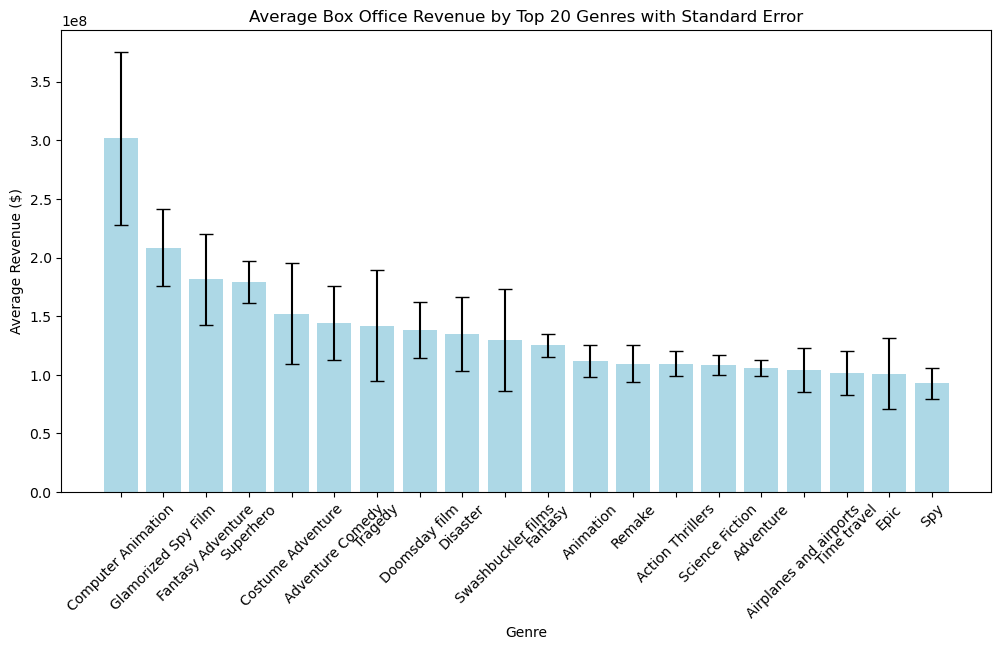

In [155]:
df_genres['all_genres'] = df_genres['all_genres'].replace({'Superhero movie': 'Superhero'})

# Calculate average revenue, standard error and count by primary genre 
genre_stats = df_genres.groupby('all_genres')['box_office_revenue'].agg(['mean', 'sem', 'count'])

#We filter out those that are not statistically relevant
genre_stats = genre_stats[genre_stats['count'] >= 30] 

# Select the top 20 genres with the highest average revenue
top_20_genres = genre_stats.sort_values(by='mean', ascending=False).head(20)

# Print the average revenue by genre
print("Average Box Office Revenue by Top 20 Genres:")
print(top_20_genres)

# Plot the average revenue by genre
plt.figure(figsize=(12, 6))
plt.bar(top_20_genres.index, top_20_genres['mean'], yerr=top_20_genres['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Top 20 Genres with Standard Error')
plt.xlabel('Genre')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis of Average Box Office Revenue by Genre

The results indicate the following top average revenues by genre:

- **Computer Animation**: $301.54 million
- **Glamorized Spy Film**: $208.46 million
- **Fantasy Adventure**: $181.38 million
- **Superhero**: $179.11 million

##### Observations

1. **Highest revenue for computer animation**: Computer-animated films now lead in average revenue, reaching $301.54 million. These films are watched by both children and adults, allowing for wide demographic appeal and strong family-friendly marketability. Their titles popularity and high-quality visuals effects make them especially attractive for many audiences of different cultueres.

2. **Glamorized spy films and superheroes are popular choices**: With average revenues of $208.46 million and $179.11 million, glamorized spy films and superhero movies maintain high popularity. Their action-packed storylines with iconic characters contribute to high box office earnings, especially in international markets for american movies. Pairing these genres with well-known actors and directors can boost their appeal across diverse audience segments. Superheroes movies also have very low standard error respect to the other genres.

##### Possible Causes

1. **Audience preference for high-production genres**: Genres with high production values, like computer animation and glamorized spy films, typically have larger budgets that allow for impressive visual effects and catch audiences looking for superlative cinematic experiences.

2. **Brand recognition**: Genres with established franchise potential, such as superhero consistently perform well. Brand recognition and affidability makes people fall in love with those movies, contributing to these genres’ high revenue.

5. **Appeal to different generations**: Genres like computer animation and fantasy adventure appeal to various demographic groups, from families to younger audiences. This broad appeal contributes to stronger box office performance, as these genres are accessible to diverse age groups.


### How does film runtime correlate with box office revenue, and do longer or shorter films tend to perform better?
- Analyze revenue by runtime to see if longer or shorter films tend to perform better.


Average Box Office Revenue by Runtime Category:
runtime_category
Short     3.880062e+07
Medium    4.462968e+07
Long      8.806463e+07
Name: mean, dtype: float64

Runtime definitions based on quantiles:
- Short: ≤ 96.0 minutes
- Medium: 97.0-110.0 minutes
- Long: > 111.0 minutes


/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/610124063.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])


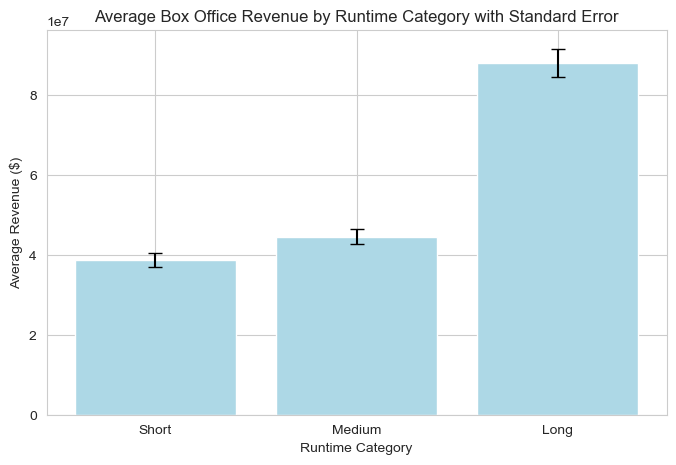

Pearson correlation between release year and runtime: PearsonRResult(statistic=0.20007012406986485, pvalue=2.0701345290884565e-51)


In [270]:
# Define runtime bins based on quantiles for equal-sized groups
df_movies['runtime_category'] = pd.qcut(df_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])

# Verify the approximate runtime boundaries for each category
short_max = df_movies[df_movies['runtime_category'] == "Short"]['runtime'].max()
medium_min = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].min()
medium_max = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].max()
long_min = df_movies[df_movies['runtime_category'] == "Long"]['runtime'].min()

# Calculate average revenue and sem by runtime category
runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenue by runtime category
print("Average Box Office Revenue by Runtime Category:")
print(runtime_stats['mean'])
print(f"\nRuntime definitions based on quantiles:\n- Short: ≤ {short_max} minutes\n- Medium: {medium_min}-{medium_max} minutes\n- Long: > {long_min} minutes")

# Plot the average revenue by runtime category
plt.figure(figsize=(8, 5))
plt.bar(runtime_stats.index, runtime_stats['mean'], yerr=runtime_stats['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Runtime Category with Standard Error')
plt.xlabel('Runtime Category')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=0)
plt.show()

# Calculate pearson correlation
df_movies_after_80s = df_movies[df_movies['release_year'] > 1980]
print(f"Pearson correlation between release year and runtime: {stats.pearsonr(df_movies_after_80s['box_office_revenue'], df_movies_after_80s['runtime'])}")

#### Analysis of Average Box Office Revenue by Film Runtime

The runtime categories, divided into equal-sized groups based on quantiles, are defined as follows:

- **Short Films**: Runtime of 96 minutes or less
- **Medium Films**: Runtime between 97 and 110 minutes
- **Long Films**: Runtime greater than 111 minutes

The average box office revenues based on these runtime categories are as follows:

- **Short Films**: $31.26 million
- **Medium Films**: $38.77 million
- **Long Films**: $78.21 million

##### Observations
Observation are back by the Pearson's correlation coefficient whihc indicates a small (0.20) but significant (p < 0.05) correlation between runtime and revenue. Basically, longer films would mean larger revenue. But in order to be more accurate, we consider films made after the 80s since before, films were obviously shorter and performing less. 

1. **Significantly higher revenue for longer films**: Films with a runtime over 111 minutes ("Long") have a considerably higher average revenue, nearly double that of medium-length films and more than double that of short films. This suggests that audiences may be more inclined to invest in longer, more immersive film experiences.

3. **Lower revenue for short films**: Films with runtimes of 96 minutes or less ("Short") yield the lowest average revenue, which may suggest a limited appeal.

##### Possible Causes

1. **More storytelling in long films**: Longer runtimes allow for more complex plot development and character development, which can be particularly engaging, potentially leading to higher audience satisfaction and ticket sales, i.e. revenues.

2. **Higher production value and ticket prices**: Longer films may often have larger production budgets, which can contribute to high-quality visuals, effects, and top-tier cast members. These elements often appeal to audiences and justify higher ticket prices.

4. **Audience willingness to watch longer movies**: Longer films may attract dedicated audiences who value a full and long cinematic experience, while shorter films may appeal more to casual viewers, resulting in lower average box office revenue.

### Which 10 languages have the highest average box office revenue?
- Display highest 10 average box office revenue by language.

In [157]:
# Convert the 'languages' dictionary to a list of language for each movie
df_movies['all_languages'] = df_movies['languages'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

# Explode the 'all_languages' list so that each language has its own row
df_languages = df_movies.explode('all_languages')

# Count movies by language
language_counts = df_languages['all_languages'].value_counts()
print("Number of Movies by language:")
print(language_counts)

Number of Movies by language:
all_languages
English Language                 7357
French Language                   534
Spanish Language                  426
German Language                   266
Korean Language                   249
                                 ... 
Korean Sign Language                1
Kinyarwanda language                1
Luxembourgish language              1
Napoletano-Calabrese Language       1
Standard Tibetan                    1
Name: count, Length: 143, dtype: int64


/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/108683771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['all_languages'] = df_movies['languages'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])


Average Box Office Revenue by Top 10 Languages:
                             mean           sem  count
all_languages                                         
Latin Language       1.390445e+08  2.685478e+07     49
Portuguese Language  1.193924e+08  2.735045e+07     45
Russian Language     1.121709e+08  1.713088e+07    185
Arabic Language      1.045101e+08  1.536502e+07     81
Hebrew Language      1.011653e+08  2.350782e+07     46
Spanish Language     9.025904e+07  9.570342e+06    426
Italian Language     8.977924e+07  1.228346e+07    239
Standard Mandarin    8.788047e+07  1.377057e+07    116
German Language      8.657641e+07  1.077494e+07    266
French Language      8.292300e+07  7.269103e+06    534


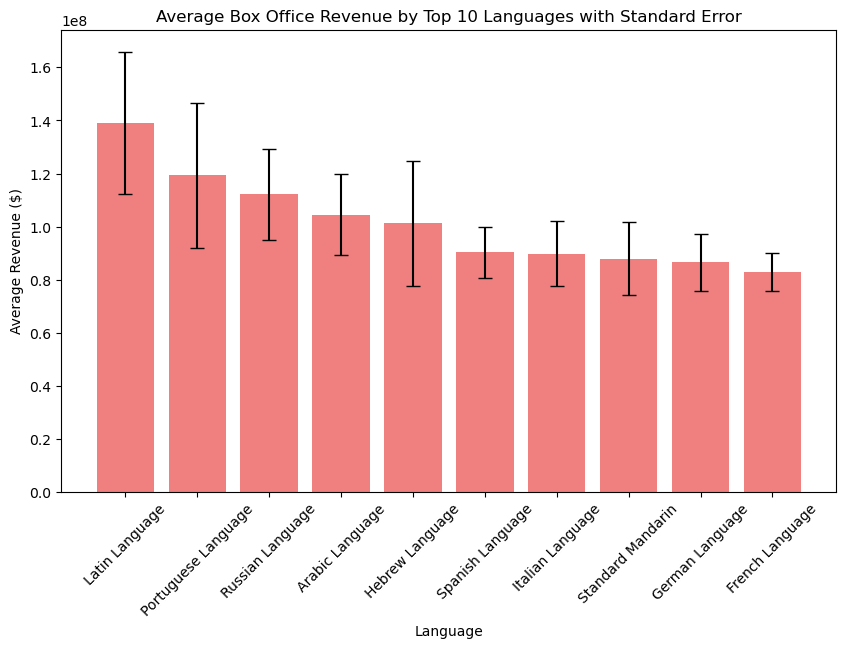

In [158]:
# Calculate average revenue, standard error and count by primary language
language_stats = df_languages.groupby('all_languages')['box_office_revenue'].agg(['mean', 'sem', 'count'])

# We filter out the statistically irrelevant languages
language_stats = language_stats[language_stats['count'] >= 30]

# Select the top 10 languages with the highest average revenue
top_10_languages = language_stats.sort_values(by='mean', ascending=False).head(10)

# Print the average revenue by language
print("Average Box Office Revenue by Top 10 Languages:")
print(top_10_languages)

# Plot the average revenue by language
plt.figure(figsize=(10, 6))
plt.bar(top_10_languages.index, top_10_languages['mean'], yerr=top_10_languages['sem'], color='lightcoral', capsize=5)
plt.title('Average Box Office Revenue by Top 10 Languages with Standard Error')
plt.xlabel('Language')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis of Average Box Office Revenue by Language

The average box office revenues based on the primary language of the films are as follows:

- **Latin Language**: $139.04 million
- **Portuguese Language**: $119.39 million
- **Russian Language**: $112.17 million
- **Arabic Language**: $104.51 million
- **Hebrew Language**: $101.17 million
- **Spanish Language**: $90.26 million
- **Italian Language**: $89.78 million
- **Standard Mandarin**: $87.88 million
- **German Language**: $86.58 million
- **French Language**: $82.92 million

##### Observations

1. **High revenue for latin and portuguese movies**: Latin and Portuguese language films lead in average box office revenue, with $139.04 million and $119.39 million respectively. This suggests that the audience is very various, possibly fueled by the world cultural significance of films produced in these languages. Noticeably portuguese movies have a high standard error compared to the other languages, this means that the revenue predictions for portuguese movies could not be very accurate.

2. **Strong performance of russian and arabic films**: Russian and Arabic language films also show high average revenues, at over $100 million each, likely benefiting from the significant number of speakers worldwide especially arabic.

3. **Broad appeal of spanish and italian movies**: Spanish and Italian language films maintain strong positions with substantial average revenues, likely benefiting from their famous artistic culture and global popularity of films in these languages.

4. **Consistent success across major european languages**: Languages like French, German, and Italian continue to perform well, highlighting the broad European and global appeal of films in these languages, likely driven by diverse themes and robust cinematic traditions.

##### Possible Causes

1. **Cultural resonance and international appeal**: Films in languages such as Latin, Italian, Portuguese, and Spanish may have better results with international audiences, who are drawn to culturally rich narratives and the broad linguistic appeal of these languages.

2. **Large domestic audiences**: Languages with substantial domestic communities, such as Russian and Arabic, can attract a huge part of the locals who connect with these films' cultural themes.

3. **Cinematic traditions**: European languages like French and Italian benefit from strong cinematic traditions, with films that appeal across multiple countries and cultural contexts.

### Which 10 actors have the highest average box office revenue?

In [159]:
# Keep only actors with at least 20 movies (to filter out less relevant actors) # TODO change to 10?
actors_count = df_actors_revenues['actor_name'].value_counts()
actors_count = actors_count[actors_count >= 20]

relevant_characters = df_actors_revenues[df_actors_revenues['actor_name'].isin(actors_count.index)]

# calculate the average revenue for each actor
actors_revenues = relevant_characters.groupby('actor_name')['box_office_revenue'].mean()

# Create a dataframe with the average revenue and number of movies for each actor
df_actors_info = pd.DataFrame({
    'mean_revenue': actors_revenues,
    'n_movies': actors_count
})

# Print the top 10 actors by average revenue
print("Top 10 Actors by Average Box Office Revenue:")
df_actors_info.sort_values(by='mean_revenue', ascending=False).head(10)

Top 10 Actors by Average Box Office Revenue:


,mean_revenue,n_movies
actor_name,,
Hugo Weaving,3.706721e+08,24
Alan Rickman,3.520243e+08,29
Robbie Coltrane,3.364884e+08,30
Maggie Smith,3.200121e+08,29
John Rhys-Davies,3.135264e+08,20
Richard Griffiths,3.086754e+08,21
Will Smith,3.083475e+08,20
Helena Bonham Carter,3.022026e+08,26
Christopher Lee,2.943084e+08,25


In [160]:
# TODO might be interesting ? but dont change much
# Calculate Z-score for each column
df_actors_info['z_mean_revenue'] = (df_actors_info['mean_revenue'] - df_actors_info['mean_revenue'].mean()) / df_actors_info['mean_revenue'].std()
df_actors_info['z_n_movies'] = (df_actors_info['n_movies'] - df_actors_info['n_movies'].mean()) / df_actors_info['n_movies'].std()

# Combine the Z-scores with weights to calculate the final score
df_actors_info['final_score'] = (df_actors_info['z_mean_revenue'] * 0.8) + (df_actors_info['z_n_movies'] * 0.2)

# Print the top 10 actors by final score
print("Top 10 Actors by Average Box Office Revenue:")
df_actors_info.sort_values(by='final_score', ascending=False).head(10)

Top 10 Actors by Average Box Office Revenue:


,mean_revenue,n_movies,z_mean_revenue,z_n_movies,final_score
actor_name,,,,,
Hugo Weaving,3.706721e+08,24,4.710861,-0.529453,3.662798
Alan Rickman,3.520243e+08,29,4.397947,0.115758,3.541509
Robbie Coltrane,3.364884e+08,30,4.137251,0.244801,3.358761
Maggie Smith,3.200121e+08,29,3.860775,0.115758,3.111772
Helena Bonham Carter,3.022026e+08,26,3.561928,-0.271368,2.795269
John Rhys-Davies,3.135264e+08,20,3.751943,-1.045622,2.792430
Richard Griffiths,3.086754e+08,21,3.670542,-0.916579,2.753118
Will Smith,3.083475e+08,20,3.665041,-1.045622,2.722908
Timothy Spall,2.930718e+08,26,3.408711,-0.271368,2.672695


#### Analysis of Average Box Office Revenue by Actor

The average box office revenues based on the primary actors in the films are as follows:

- **Hugo Weaving**: $370.67 million
- **Alan Rickman**: $352.02 million
- **Robbie Coltrane**: $336.49 million
- **Maggie Smith**: $320.01 million
- **John Rhys-Davies**: $313.53 million
- **Richard Griffiths**: $308.68 million
- **Will Smith**: $308.35 million
- **Helena Bonham Carter**: $302.20 million
- **Christopher Lee**: $294.31 million
- **Timothy Spall**: $293.07 million

##### Observations

1. **Top performers with strong box office returns**: Actors like **Hugo Weaving**, **Alan Rickman**, and **Robbie Coltrane** lead in average box office revenue, all exceeding $330 million. This can be attributed to their roles in highly successful franchises such as *The Lord of the Rings* and *Harry Potter*, where their performances were central to the films' broad global appeal.

2. **Strong performances by veteran actors**: Many of the top actors, including **Maggie Smith**, **John Rhys-Davies**, and **Richard Griffiths**, have strong box office returns, likely due to their consistent roles in large franchises, particularly within the fantasy and adventure genres. Their longevity in the industry has allowed them to be part of major cinematic events that consistently draw large audiences.

##### Possible Causes

1. **Important titles bring high revenues**: Actors associated with successful franchises, such as the *Harry Potter* and *The Lord of the Rings* series, tend to have higher average box office revenues due to the repeated success of these films and their lasting popularity with audiences.

2. **Broad international reach**: Actors like **Will Smith** have the advantage of global appeal, often present in american movies that have a broad international reach.

3. **Veteran status**: Many of these actors have been in the industry for decades, which allows them to participate in high-budget films with significant box office potential. Their established reputations and fan loyalty contribute to their sustained success.

### Does ethnicity, age or gender of leading actors influences box office revenue ?

In [161]:
# Average Box Office Revenue by Actors Age Group
df_actors_revenues['actor_age_group'] = df_actors_revenues['actor_age'].apply(data_utils.categorize_age_group)

# Calculate average revenues and standard error for each age group
age_stats = df_actors_revenues.groupby('actor_age_group')['box_office_revenue'].agg(['mean', 'count', 'sem'])
# Order the age groups
age_stats = age_stats.loc[['child', 'teen', 'young_adult', 'adult', 'senior']]

# Print the average revenues by age group
print("Average Box Office Revenue by Actors Age:")
print(age_stats)

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(age_stats.index, age_stats['mean'], yerr=age_stats['sem'], color=['lightblue', 'lightgreen', 'moccasin', 'orange', 'lightpink'], capsize=5)
plt.title('Average Box Office Revenue by Actors Age with Standard error')
plt.xlabel('Actor Age Group')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

AttributeError: module 'src.utils.data_utils' has no attribute 'categorize_age_group'

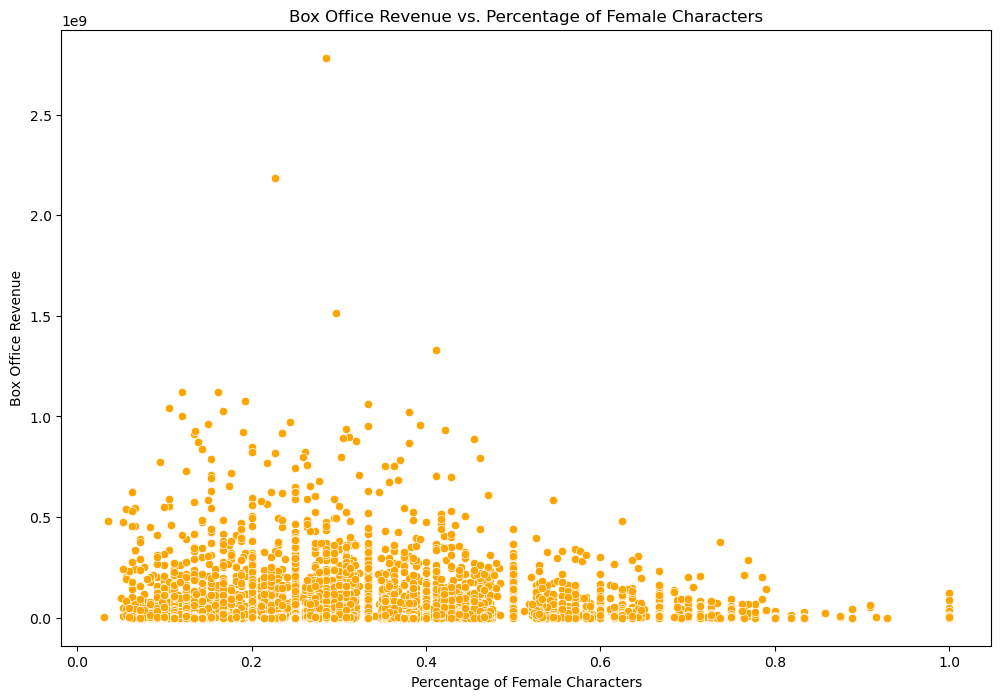

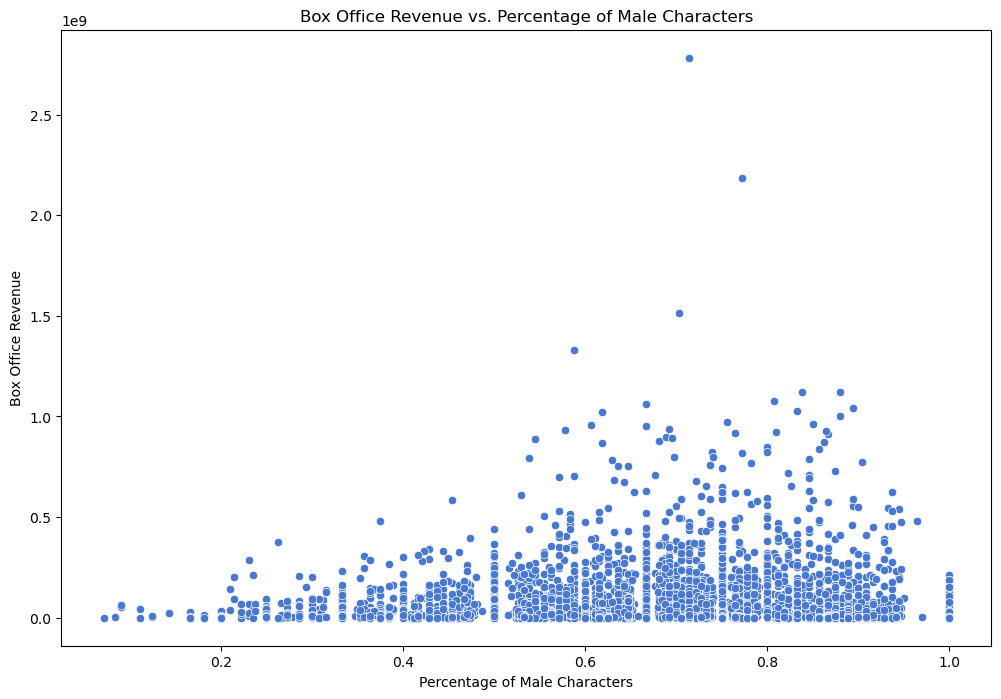

Average Box Office Revenue by Actors Gender Dominance:
dominant_gender
Balanced    2.355796e+07
Female      3.226714e+07
Male        5.438415e+07
Name: mean, dtype: float64


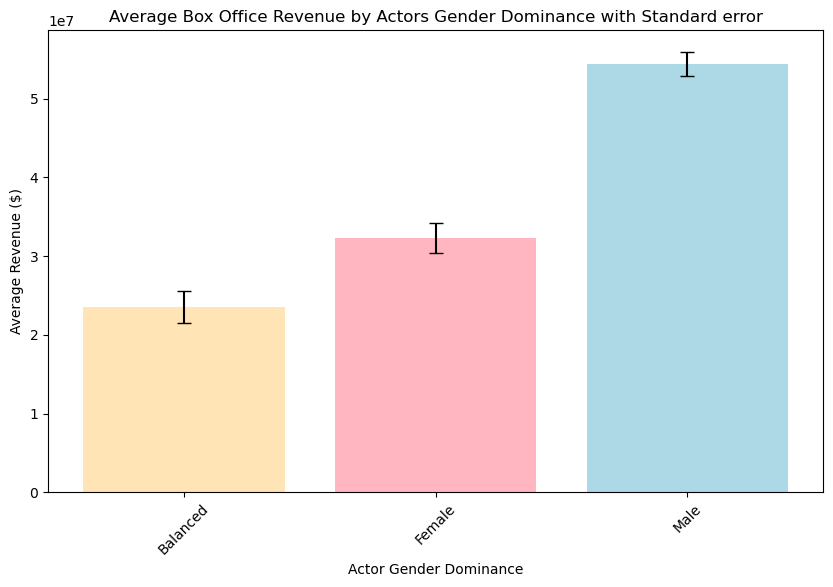

In [162]:
# Box office revenue based on the gender of the actors? 
movies_dominant_gender = df_actors_revenues.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_gender'].value_counts(normalize=True).unstack().reset_index()
movies_dominant_gender = movies_dominant_gender.rename(columns={'F': 'Female', 'M': 'Male'})
movies_dominant_gender['dominant_gender'] = movies_dominant_gender.apply(
    lambda row: 'Balanced' if row['Male'] == row['Female'] else row[['Male', 'Female']].idxmax(), axis=1
)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=movies_dominant_gender, x='Female', y='box_office_revenue', color='orange')
plt.xlabel('Percentage of Female Characters')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue vs. Percentage of Female Characters')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=movies_dominant_gender, x='Male', y='box_office_revenue')
plt.xlabel('Percentage of Male Characters')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue vs. Percentage of Male Characters')
plt.show()

gender_stats = movies_dominant_gender.groupby('dominant_gender')['box_office_revenue'].agg(['mean', 'count', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Actors Gender Dominance:")
print(gender_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(gender_stats.index, gender_stats['mean'], yerr=gender_stats['sem'], color=['moccasin', 'lightpink', 'lightblue'], capsize=5)
plt.title('Average Box Office Revenue by Actors Gender Dominance with Standard error')
plt.xlabel('Actor Gender Dominance')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

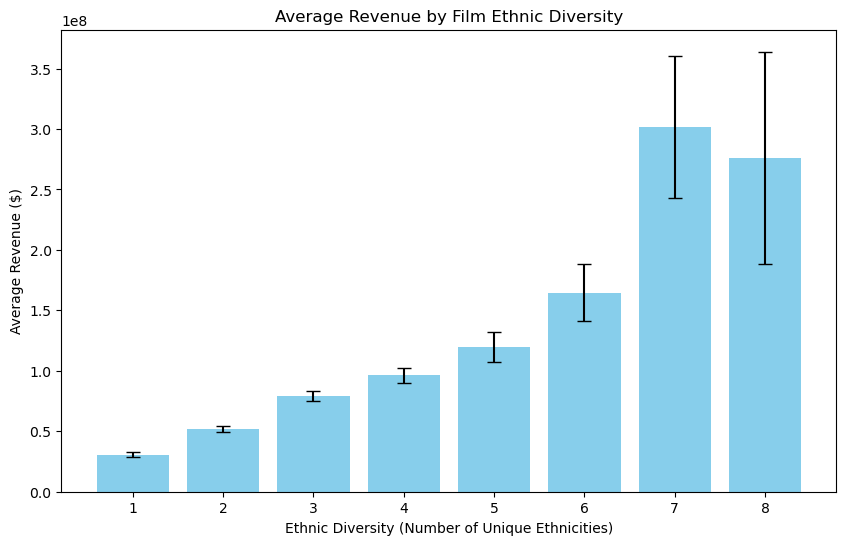

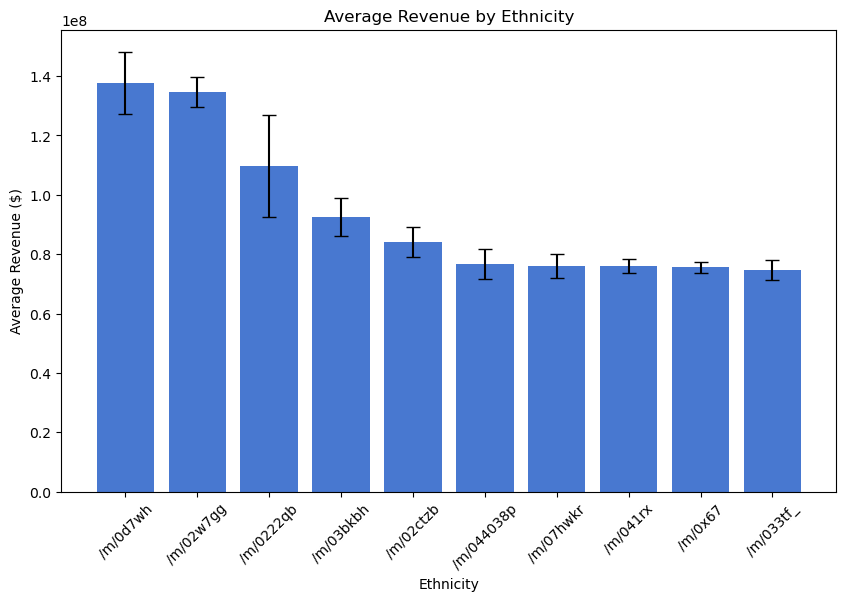

In [163]:
# Explode the 'actor_ethnicity' (an actor can have several ethnicities)
df_exploded = df_actors_revenues.explode('actor_ethnicity')

# Keep only the ethnicities with more than 50 actors
ethnicity_count = df_exploded.groupby('actor_ethnicity')['actor_name'].nunique().reset_index()
ethnicity_count.columns = ['actor_ethnicity', 'num_atores']

relevant_ethnicities = ethnicity_count[ethnicity_count['num_atores'] > 50]
df_filtered = df_exploded[df_exploded['actor_ethnicity'].isin(relevant_ethnicities['actor_ethnicity'])]

# Calculate the diversity for each movie
diversity_per_movie = df_filtered.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_ethnicity'].nunique().reset_index()
diversity_per_movie.columns = ['wikipedia_movie_id', 'box_office_revenue', 'diversity']

revenue_per_diversity = diversity_per_movie.groupby('diversity')['box_office_revenue'].agg(['mean', 'count', 'sem'])

# Print the average revenue by diversity
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_diversity.index, revenue_per_diversity['mean'], yerr=revenue_per_diversity['sem'], color='skyblue', capsize=5)
plt.xticks(revenue_per_diversity.index)
plt.xlabel('Ethnic Diversity (Number of Unique Ethnicities)')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by Film Ethnic Diversity')
plt.show()

# Calculate the average revenue by ethnicity 
revenue_per_ethnicity = df_filtered.groupby('actor_ethnicity')['box_office_revenue'].agg(['mean', 'count', 'sem'])
revenue_per_ethnicity = revenue_per_ethnicity.sort_values(by='mean', ascending=False).head(10)

# Print the average revenue by ethnicity
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_ethnicity.index, revenue_per_ethnicity['mean'], yerr=revenue_per_ethnicity['sem'], capsize=5)
plt.xlabel('Ethnicity')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by Ethnicity')
plt.xticks(rotation=45)
plt.show()


## Part 3 : Investigation of features' possible correlation

Now that we understand features seperatly and how they influence the box office revenue, we want to investigate possible correlation between features. To achieve this, we are going to address the following questions : 
- Does the film language influences revenue in a specific country ?
- Does some countries prefer a specific genre ?
- Which languages perform better outside of where they are spoken ?
- How box office revenues changed in critical world situations (pandemic, economic crisis) ?
- How does these features have evolved over time ?

### Does the film language influences revenue in a specific country ?

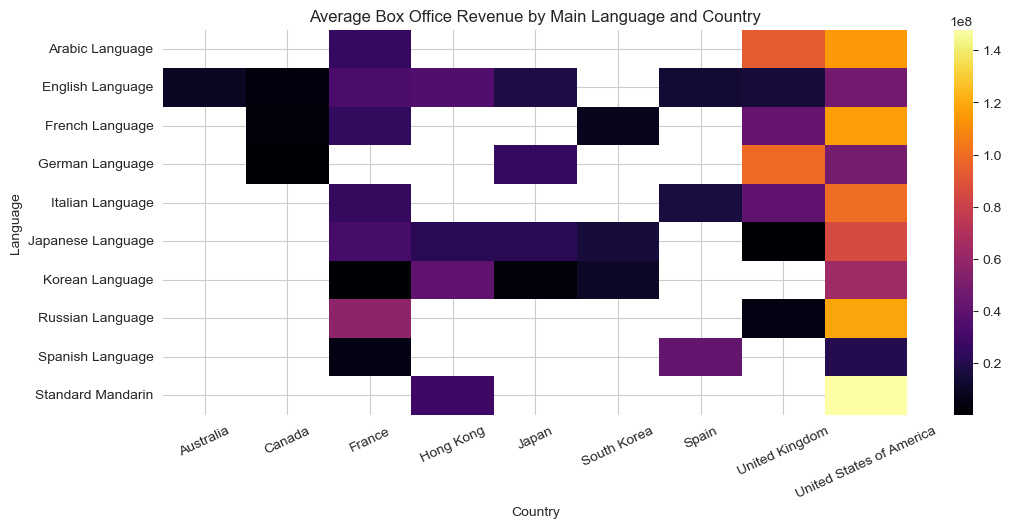

In [224]:
# plot an heatmap of languages and countries to revenue
df_languages_countries = df_movies[['languages', 'countries', 'box_office_revenue']].copy()

df_languages_countries['all_languages'] = df_languages_countries['languages'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])
df_languages_countries['all_countries'] = df_languages_countries['countries'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])


df_languages_countries['main_language'] = df_languages_countries['all_languages'].apply(lambda x: x[0] if x else None)
df_languages_countries['main_country'] = df_languages_countries['all_countries'].apply(lambda x: x[0] if x else None)

# keep only the top 10 languages and countries
top_10_languages = df_languages_countries['main_language'].value_counts().head(10).index
top_10_countries = df_languages_countries['main_country'].value_counts().head(10).index
df_languages_countries = df_languages_countries[df_languages_countries['main_language'].isin(top_10_languages)]
df_languages_countries = df_languages_countries[df_languages_countries['main_country'].isin(top_10_countries)]

# Plot heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(df_languages_countries.pivot_table(index='main_language', columns='main_country', values='box_office_revenue', aggfunc='mean'), cmap='inferno')
plt.title('Average Box Office Revenue by Main Language and Country')
plt.xlabel('Country')
plt.xticks(rotation=25)
plt.ylabel('Language')
plt.show()

#### Analysis

It is very interesting to see that some combination of language and country are more financially interesting than others. we can defenitly see that producing a film in the US is better regardless of the language but perfrom the best with mandarin, russian and arabic ! We can also see that UK performs well for films with arabic or german as language.

### How does these features have evolved over time ?

we discovered some trends during the EDA analysis but to give an accurate advice to film producers, we need to understand if trends are coming, leaving or have always been there. Therefore, analyse how it has changed overtime will give us a good understanding on that.

#### Box office revenue through the years

Pearson correlation between release year and box office revenue: PearsonRResult(statistic=0.17988378948343398, pvalue=4.732576940359851e-50)


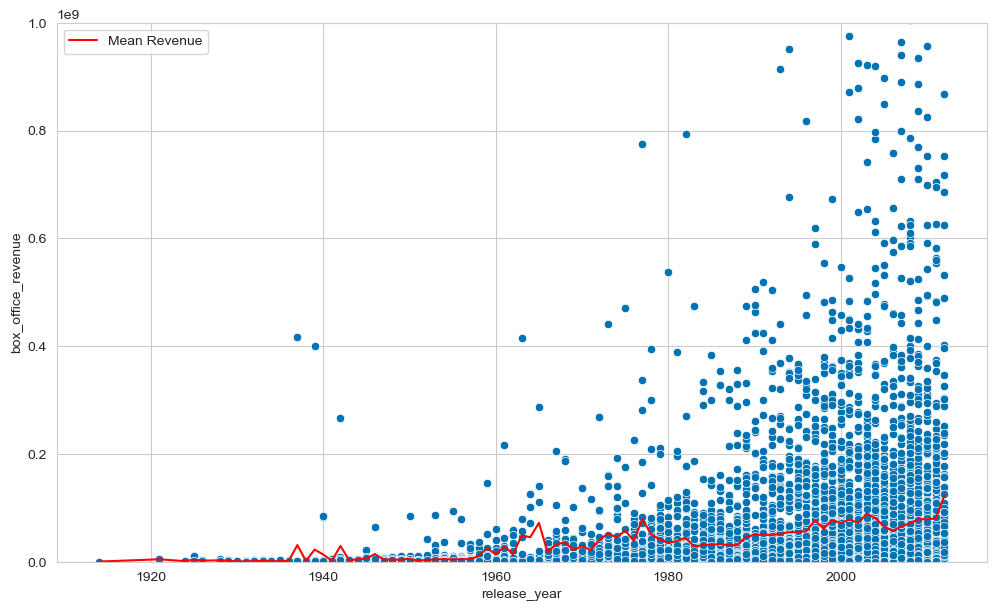

In [251]:
# Plot the box office revenue for each film over the years
df_movies['release_year'] = df_movies['release_date'].dt.year
df_movies = df_movies.dropna(subset=['release_year'])

plt.figure(figsize=(12, 7))
plt.ylim(0, 1e9)
sns.scatterplot(data=df_movies, x='release_year', y='box_office_revenue')

# Plot the mean box office revenue as a line
mean_revenue_per_year = df_movies.groupby('release_year')['box_office_revenue'].mean().reset_index()
sns.lineplot(data=mean_revenue_per_year, x='release_year', y='box_office_revenue', color='red', label='Mean Revenue')

# Calculate pearson correlation
print(f"Pearson correlation between release year and box office revenue: {stats.pearsonr(df_movies['release_year'], df_movies['box_office_revenue'])}")


##### Analysis

It is nice to see that the industry is not dying ! At first glance, we see of course more movies and thus the revenue is more diverse. But thanks to the mean and the Pearson correlation coefficient along the the pvalue, we can be sure that there is a small (0.18) but significant (p < 0.05) correlation between time and revenue.

Moreover, we can see that the revenue distribution is more and more spread through the decades. This means that it is possible for some movies to perform really well and enforece the idea that it is interesting to look at the factors that are allowing these results.

#### Average revenue for top genres through the years

/var/folders/y8/5683jddj2px_2pbc_j9m5pmm0000gn/T/ipykernel_20459/1577834458.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  genre_decade_stats['sem'].fillna(0, inplace=True)


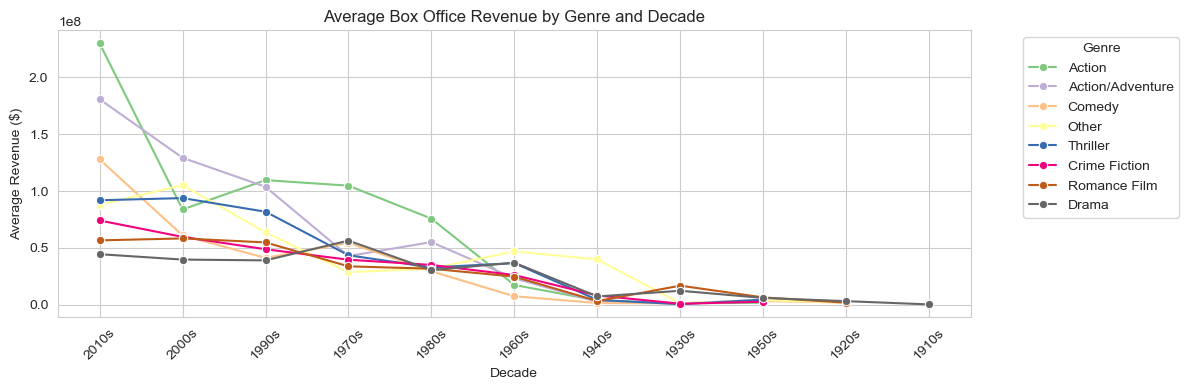

In [260]:
# Display the top 7 genres with highest average revenue for the past decades
top_genres = genre_counts_df.head(7)['genre'].tolist()

# Extract features
df_movies['main_genre'] = df_movies['all_genres'].apply(lambda x: next((genre for genre in x if genre in top_genres), 'Other'))
df_movies['release_decade'] = df_movies['release_date'].dt.year // 10 * 10
df_movies['release_decade'] = df_movies['release_decade'].astype(str) + 's'

genre_decade_stats = df_movies.groupby(['release_decade', 'main_genre'])['box_office_revenue'].agg(['mean', 'count', 'sem'])
genre_decade_stats['sem'].fillna(0, inplace=True)
genre_decade_stats.sort_values(by='mean', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 4))
sns.lineplot(data=genre_decade_stats.reset_index(), x='release_decade', y='mean', hue='main_genre', marker='o', palette='Accent')
plt.title('Average Box Office Revenue by Genre and Decade')
plt.xlabel('Decade')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Analysis

Interesting ! There is indeed some genre that are getting more and more popular in the last decades, mayber producers should focus on those one ?

#### Average runtime through the year

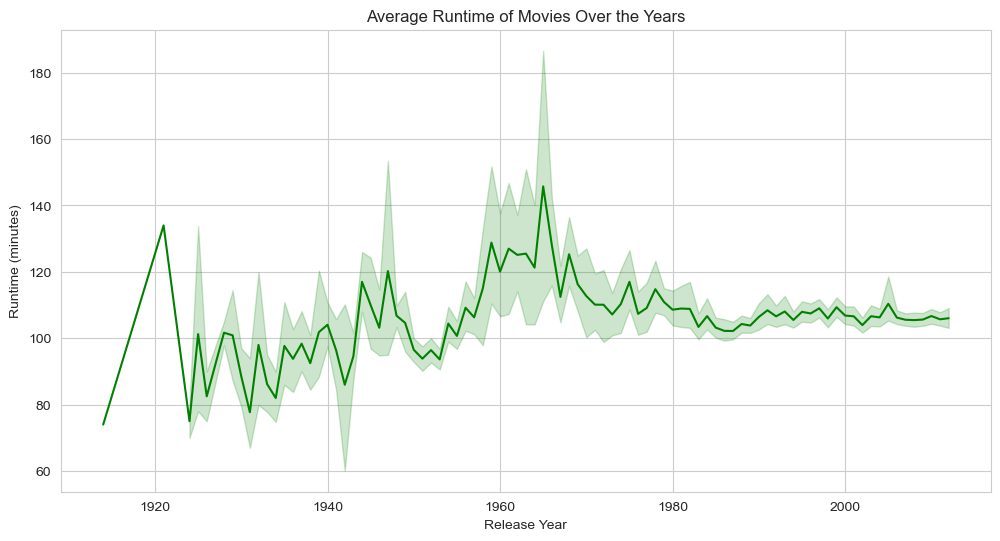

In [267]:
# plot the average runtime through the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_movies, x='release_year', y='runtime', color='green')
plt.title('Average Runtime of Movies Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Runtime (minutes)')
plt.show()


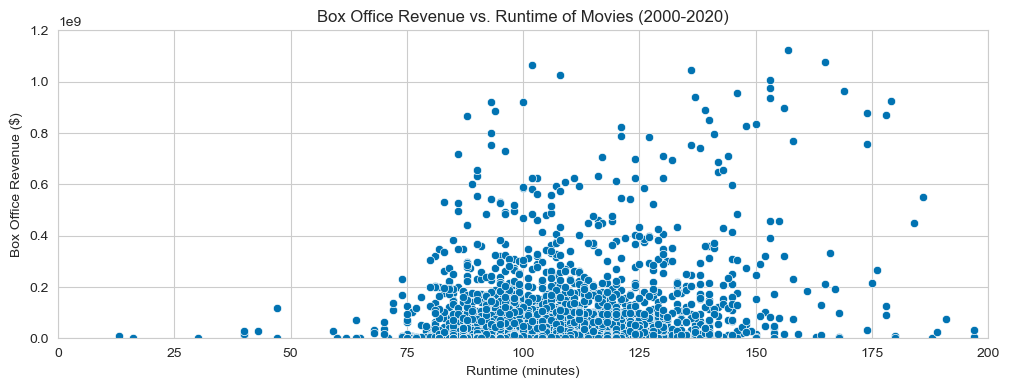

Pearson correlation between runtime and box office revenue: PearsonRResult(statistic=0.19316946823268355, pvalue=3.845354938670346e-28)


In [282]:
# focus on the past 20 years and scatter plot runtime vs revenue
df_movies_after_2000 = df_movies[df_movies['release_year'] >= 2000]

plt.figure(figsize=(12, 4))
sns.scatterplot(data=df_movies_after_2000, x='runtime', y='box_office_revenue')
plt.title('Box Office Revenue vs. Runtime of Movies (2000-2020)')
plt.xlabel('Runtime (minutes)')
plt.xlim(0, 200)
plt.ylabel('Box Office Revenue ($)')
plt.ylim(0, 1.2e9)
plt.show()

# calculate the pearson correlation
print(f"Pearson correlation between runtime and box office revenue: {stats.pearsonr(df_movies_after_2000['runtime'], df_movies_after_2000['box_office_revenue'])}")


##### Analysis

The average runtime has fluctuated a lot but seems to stabilize since the 90s. Moreover, we can see that the confidence interval narrows as weel which indicate than movie's runtime tend to uniformize. It settles aroun d 105 minutes.

The second plot focuses on the past 2 decades for a more fine-grained analysis. It aims to understand the trend of the last 20 years. As we can both see in the graph and with the pearson correlation coefficient, it seems that we have a small but significant positive correlation between runtime and revenue in the last 20 years.

## Part 4 : Create a predictive model for box office success

############################################################################# For now i tested 2 classification models and 2 regression models, I think i'm going to try svm #############################################################################

In [262]:
# import the models
import src.models.custom_logistic_regression as custom_logistic_regression
import src.models.logistic_regression as logistic_regression
import src.models.gradient_boosting_regressor as gradient_boosting_regressor
import src.models.random_forest_regression as random_forest_regression

# import the splitting library
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df = pd.read_csv('data/preprocessed/preprocessed_data.csv') 
X = df.drop(columns=['box_office_revenue']) 
y = df['box_office_revenue']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Custom Logistic Regression
custom_lr = custom_logistic_regression.CustomLogisticRegression()
custom_lr.fit(y_train, X_train, y_val, X_val)
custom_lr_results = custom_lr.evaluate(y_val, np.c_[np.ones((X_val.shape[0], 1)), X_val])
print("Custom Logistic Regression Results:", custom_lr_results)

# Logistic Regression
sklearn_lr = logistic_regression.SklearnLogisticRegression()
sklearn_lr.train(X_train, y_train)
sklearn_lr_results = sklearn_lr.evaluate(y_val, X_val)
print("Sklearn Logistic Regression Results:", sklearn_lr_results)

In [ ]:
# Random Forest Regressor
rf_model = random_forest_regression.RandomForestModel()
rf_model.train(X_train, y_train)
rf_results = rf_model.evaluate(X_val, y_val)
print("Random Forest Regressor Results:", rf_results)

# Gradient Boosting Regressor
gb_model = gradient_boosting_regressor.GradientBoostingRegressorModel()
gb_model.train(X_train, y_train)
gb_results = gb_model.evaluate(X_val, y_val)
print("Gradient Boosting Regressor Results:", gb_results)

In [ ]:
# Collect results from models
results_summary = pd.DataFrame({
    "Model": ["Custom Logistic Regression", "Sklearn Logistic Regression", "Random Forest Regressor", "Gradient Boosting Regressor"],
    "MAE": [None, None, rf_results["MAE"], gb_results["MAE"]],
    "MSE": [None, None, rf_results["MSE"], gb_results["MSE"]],
    "RMSE": [None, None, rf_results["RMSE"], gb_results["RMSE"]],
    "Precision": [custom_lr_results["Precision"], sklearn_lr_results["Precision"], None, None],
    "Recall": [custom_lr_results["Recall"], sklearn_lr_results["Recall"], None, None],
    "F1 Score": [custom_lr_results["F1 Score"], sklearn_lr_results["F1 Score"], None, None]
})

plt.figure(figsize=(16, 12))
colors = sns.color_palette("husl", len(results_summary))

# Plot MAE
if results_summary["MAE"].notnull().any():
    plt.subplot(3, 2, 1)
    sns.barplot(x="Model", y="MAE", data=results_summary, palette=colors)
    plt.title("Mean Absolute Error (MAE)")
    plt.ylabel("MAE")
    plt.xticks(rotation=45)

# Plot MSE
if results_summary["MSE"].notnull().any():
    plt.subplot(3, 2, 2)
    sns.barplot(x="Model", y="MSE", data=results_summary, palette=colors)
    plt.title("Mean Squared Error (MSE)")
    plt.ylabel("MSE")
    plt.xticks(rotation=45)

# Plot RMSE
if results_summary["RMSE"].notnull().any():
    plt.subplot(3, 2, 3)
    sns.barplot(x="Model", y="RMSE", data=results_summary, palette=colors)
    plt.title("Root Mean Squared Error (RMSE)")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)

# Plot Precision
if results_summary["Precision"].notnull().any():
    plt.subplot(3, 2, 4)
    sns.barplot(x="Model", y="Precision", data=results_summary, palette=colors)
    plt.title("Precision")
    plt.ylabel("Precision")
    plt.xticks(rotation=45)

# Plot Recall
if results_summary["Recall"].notnull().any():
    plt.subplot(3, 2, 5)
    sns.barplot(x="Model", y="Recall", data=results_summary, palette=colors)
    plt.title("Recall")
    plt.ylabel("Recall")
    plt.xticks(rotation=45)

# Plot F1 Score
if results_summary["F1 Score"].notnull().any():
    plt.subplot(3, 2, 6)
    sns.barplot(x="Model", y="F1 Score", data=results_summary, palette=colors)
    plt.title("F1 Score")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Model Comparison Summary")
print(results_summary)

## Results & conclusion

## 